In [1]:
from fmd_evolution import *
import esm # to use the PLM ESM-2
import os # to process evaluation data from MSA file
from Bio.Align import substitution_matrices

In [2]:
# Source: https://github.com/facebookresearch/esm/tree/main?tab=readme-ov-file#esmfold
model, alphabet = esm.pretrained.load_model_and_alphabet("esm2_t33_650M_UR50D") 
batch_converter = alphabet.get_batch_converter()

In [3]:
reference_seq = 'TTSAGESADPVTATVENYGGETQVQRRQHTDIAFILDRFVKVKPKEQVNVLDLMQIPAHTLVGALLRTATYYFSDLELAVKHEGDLTWVPNGAPETALDNTTNPTAYHKEPLTRLALPYTAPHRVLATVYNGSSKYGDTSTNNVRGDLQVLAQKAERTLPTSFNFGAIKATRVTELLYRMKRAETYCPRPLLAIQPSDARHKQRIVAPAKQ'

In [4]:
modelSingleton = ModelSingleton(model=model,alphabet=alphabet,batch_converter=batch_converter)

In [5]:
# mutation strategy parameters
mutations_per_seq = 4 # cap on size of potential mutation pool
min_pos = 1
max_pos = 212
constrained_start = 138 # start of high variability region
constrained_end = 143 # end of high variability region

blosum_matrix = substitution_matrices.load("BLOSUM80") 
multiplier=0.5 # for weighting blosum penalty 

mh_iterations = 10
mh_positions_per_seq = 3 # number of positions generated via mh
mh_mutations_per_seq = 3 # number of amino acids generated per pos

# evaluation strategy parameters
max_generations = 5
file_path = os.path.join("fmd_evolution/evaluation", "FMDV_VP1_HVR_1571seq_aln.fas") # can only be applied on predictions with constrained positions 138-143 - can I push this to my repo? or not supposed to be public?

In [6]:
# constrained segment to mutate
segment = list(reference_seq)[constrained_start-1:constrained_end] # convert base-1 amino acid positions to base-0 for python indexing
for pos in range(constrained_start,constrained_end+1):
    print(f"Position {pos} : Amino Acid {segment[pos-constrained_start]}")

Position 138 : Amino Acid D
Position 139 : Amino Acid T
Position 140 : Amino Acid S
Position 141 : Amino Acid T
Position 142 : Amino Acid N
Position 143 : Amino Acid N


## Evolution using Metropolis Hastings Across 6 Highly Mutable Positions

In [7]:
fmd_sequence = ProteinSequence("base",reference_seq)
eval_strat = EvaluationStrategy(root_sequence = fmd_sequence)
ranked_eval_strat = RankedEvaluationStrategy(root_sequence = fmd_sequence)
mutation_strat = MetropolisHastings(iterations=mh_iterations, positions_per_seq=mh_positions_per_seq, mutations_per_seq=mh_mutations_per_seq, start_pos=constrained_start,end_pos=constrained_end)
evolution = Evolution(
    root_sequence = fmd_sequence,
    mutation_strategy = mutation_strat,
    evaluation_strategy = eval_strat,
    ranked_evaluation_strategy = ranked_eval_strat,
    max_generations=max_generations)
evolution.process_alignment_data(file_path) # process alignment data

array(['DTSTNN', 'DTSTNN', 'DTSTNN', ..., '------', '-VSGSS', 'DVTA--'],
      dtype='<U6')

In [8]:
evolution.evolve_sequence_with_ranking()

Pool of potential mutations: [('T', 138, 'F'), ('T', 138, 'E'), ('N', 142, 'L')]
Pool of potential mutations: [('N', 141, 'P'), ('D', 137, 'V')]
Pool of potential mutations: [('D', 137, 'I'), ('N', 142, 'I'), ('D', 137, 'Y')]
Pool of potential mutations: [('T', 140, 'I'), ('S', 139, 'K'), ('V', 137, 'L')]
Pool of potential mutations: [('T', 140, 'D'), ('N', 141, 'W'), ('N', 141, 'R')]
Pool of potential mutations: [('K', 139, 'G'), ('N', 141, 'T'), ('N', 141, 'S')]
Max generations reached for this path.
Max generations reached for this path.
Pool of potential mutations: [('S', 139, 'H'), ('N', 141, 'R'), ('L', 137, 'P')]
Pool of potential mutations: [('T', 140, 'H'), ('D', 137, 'F'), ('N', 142, 'Q')]
Pool of potential mutations: [('S', 139, 'E'), ('N', 141, 'E'), ('S', 139, 'I')]


In [9]:
# evolution.evolve_sequence() # positions are 0-indexed, adjusted later for graph, fitness landscape, mutation score z axis, y axis pos 1 (all possible aas), y pos 2 (same), order the aminoa cids correctly! using embeddings for what's similar/close

/home/ilmmbis/anaconda3/envs/evolocity_env/lib/python3.7/site-packages/networkx/drawing/layout.py:727: RuntimeWarning: divide by zero encountered in true_divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)


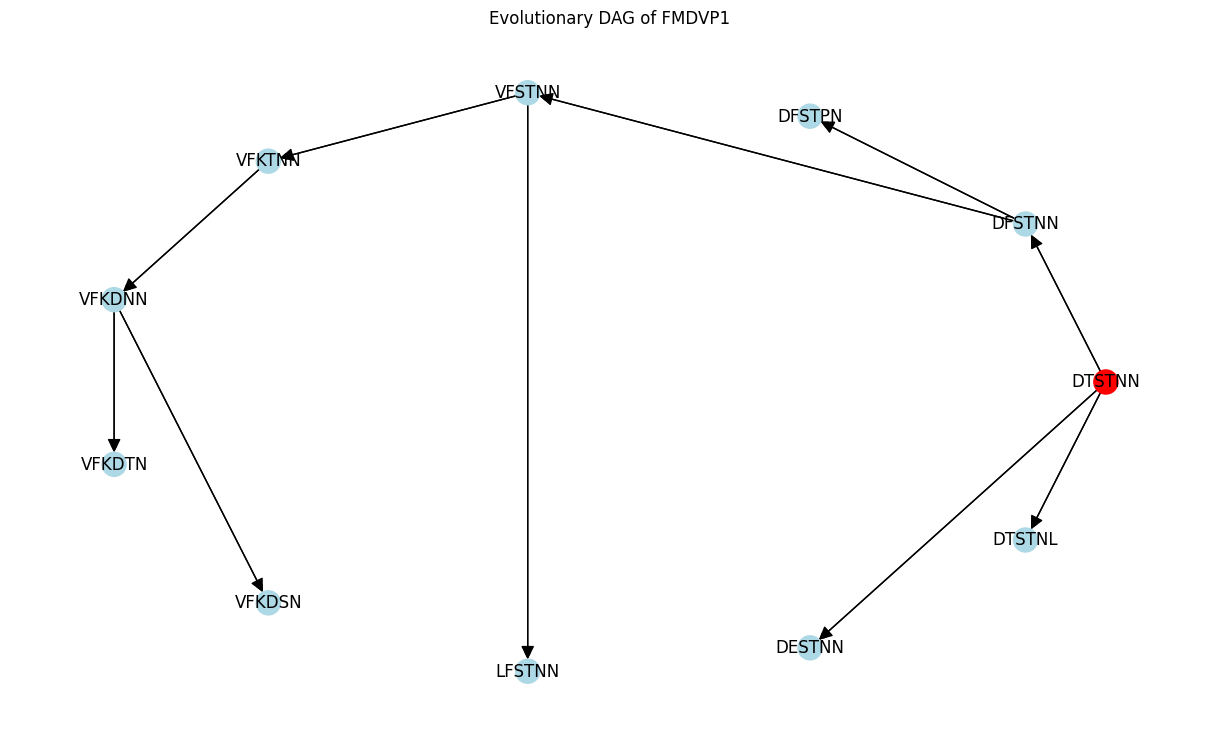

In [10]:
evolution.visualise_graph() 

In [11]:
sorted_paths = evolution.get_best_paths_in_order() # paths to leaf nodes only
print(f"Number of paths generated: {len(sorted_paths)}") # sorted by mean mutation score for path

Number of paths generated: 6


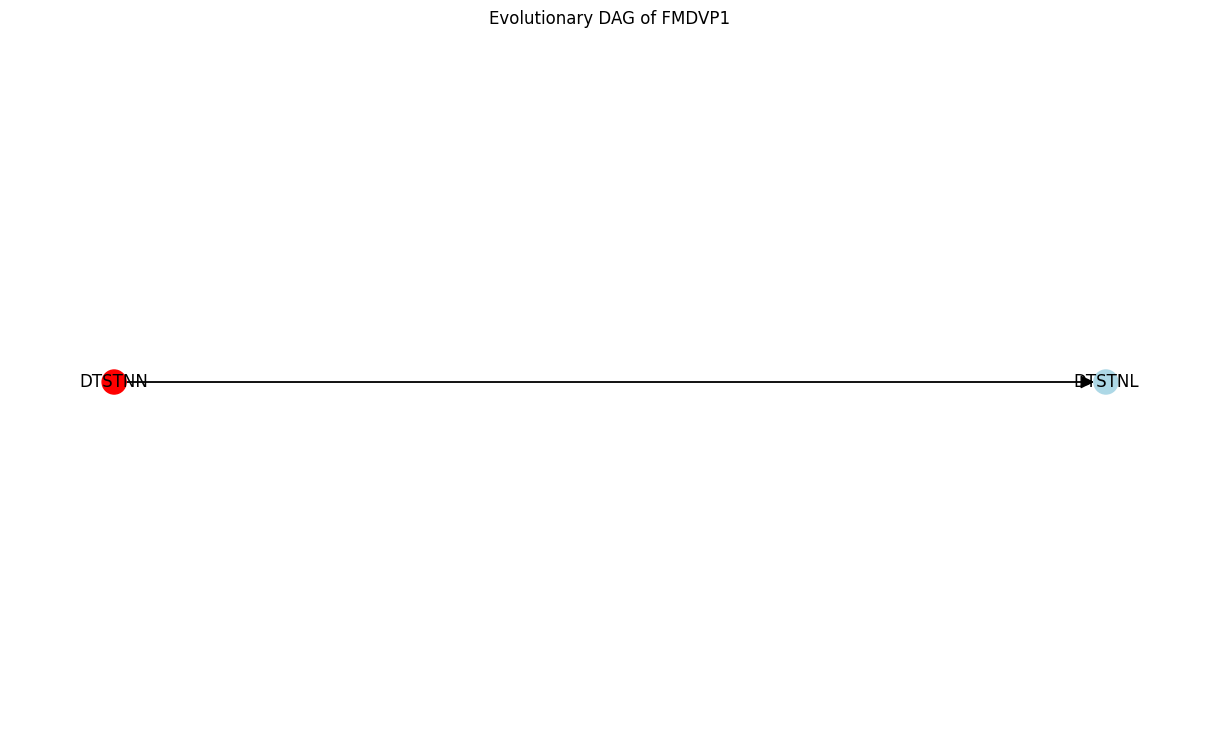

% of mutation matches for N143L: 0.0%


In [12]:
best_path = sorted_paths[0][1]
evolution.visualise_graph(best_path)
best_path_metrics = evolution.evaluate_path_using_alignments(evolutionary_path=best_path)

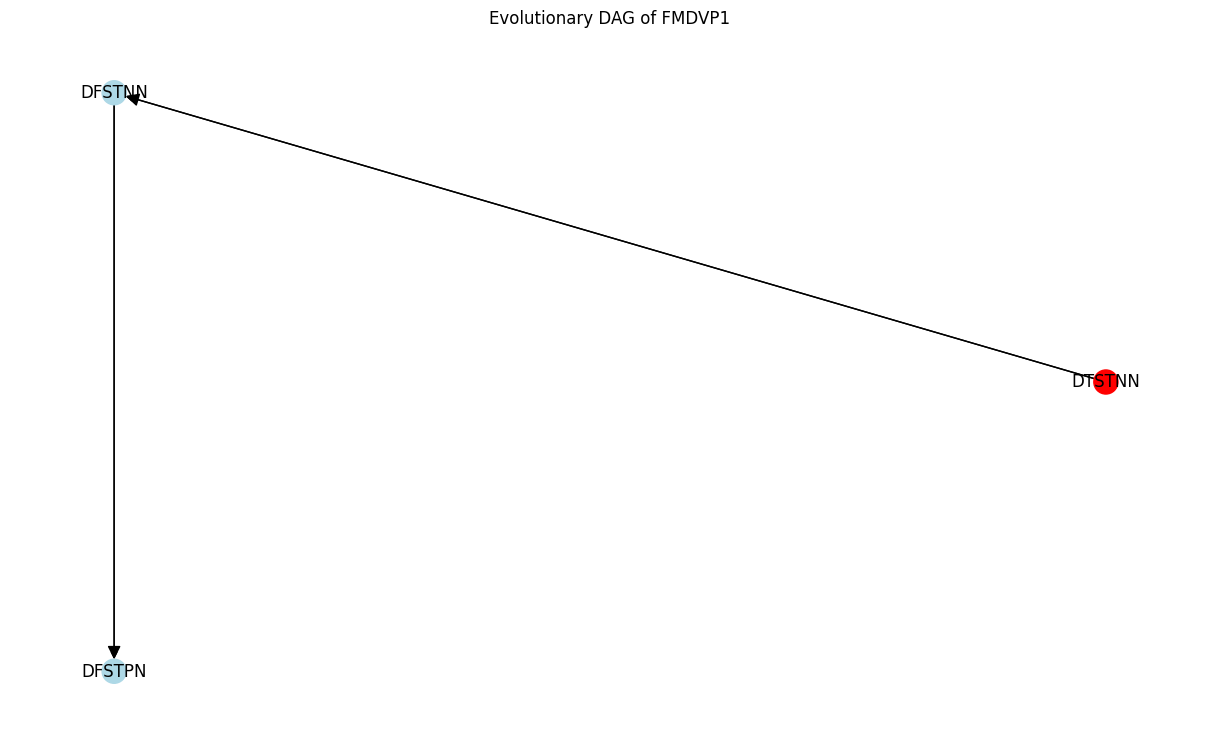

% of mutation matches for T139F: 0.0%
% of mutation matches for N142P: 19.48%


In [13]:
worst_path = sorted_paths[-1][1]
evolution.visualise_graph(worst_path)
worst_path_metrics = evolution.evaluate_path_using_alignments(evolutionary_path=worst_path)

% of mutation matches for N143L: 0.0%
% of mutation matches for T139E: 3.44%
% of mutation matches for T139F: 0.0%
% of mutation matches for D138V: 0.19%
% of mutation matches for S140K: 0.13%
% of mutation matches for T141D: 0.32%
% of mutation matches for N142T: 37.56%
% of mutation matches for T139F: 0.0%
% of mutation matches for D138V: 0.19%
% of mutation matches for S140K: 0.13%
% of mutation matches for T141D: 0.32%
% of mutation matches for N142S: 13.94%
% of mutation matches for T139F: 0.0%
% of mutation matches for D138V: 0.19%
% of mutation matches for V138L: 0.0%
% of mutation matches for T139F: 0.0%
% of mutation matches for N142P: 19.48%


Text(0.5, 1.0, 'Average Mutuation Match % Across Generated Evolutionary Paths')

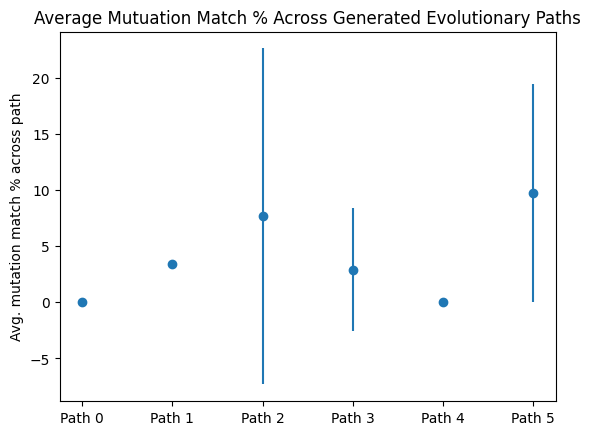

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# create graphs of path means with error bars
paths_metrics = [evolution.evaluate_path_using_alignments(evolutionary_path=path) for average_mutation_score,path in sorted_paths]

means = [np.mean(path) for path in paths_metrics]
std_devs = [np.std(path) for path in paths_metrics]
x_positions = range(len(sorted_paths))
path_names = [f"Path {n}" for n in x_positions]
plt.errorbar(x=x_positions,y=means,yerr=std_devs,fmt='o')
plt.xticks(x_positions,path_names)
plt.ylabel("Avg. mutation match % across path")
plt.title("Average Mutuation Match % Across Generated Evolutionary Paths")

## Evolution using Metropolis Hastings Across All 212 Positions

In [15]:
fmd_sequence = ProteinSequence("base",reference_seq)
eval_strat = EvaluationStrategy(root_sequence = fmd_sequence)
mutation_strat = mutation_strat = MetropolisHastings(iterations=mh_iterations, positions_per_seq=mh_positions_per_seq, mutations_per_seq=mh_mutations_per_seq, start_pos=min_pos,end_pos=max_pos)
evolution = Evolution(
    root_sequence = fmd_sequence,
    mutation_strategy = mutation_strat,
    evaluation_strategy = eval_strat,
    max_generations=max_generations)

TypeError: __init__() missing 1 required positional argument: 'ranked_evaluation_strategy'

In [14]:
evolution.evolve_sequence() 

Max generations reached for this path.
Max generations reached for this path.
Max generations reached for this path.


In [ ]:
evolution.visualise_graph() 

In [ ]:
sorted_best_paths = evolution.get_best_paths_in_order() # paths to leaf nodes only
print(f"Number of paths generated: {len(sorted_best_paths)}") # sorted by mean mutation score for path

In [ ]:
best_path = sorted_best_paths[0][1]
evolution.visualise_graph(best_path)

In [ ]:
worst_path = sorted_best_paths[-1][1]
evolution.visualise_graph(worst_path)

## Evolution using Mininimum and Maximum Logits Across 6 Highly Mutable Positions

In [19]:
fmd_sequence = ProteinSequence("base",reference_seq)
eval_strat = EvaluationStrategy(root_sequence=fmd_sequence)
mutation_strat = MinLogitPosSub(mutations_per_seq=mutations_per_seq,start_pos=constrained_start,end_pos=constrained_end)
evolution = Evolution(
    root_sequence = fmd_sequence,
    mutation_strategy = mutation_strat,
    evaluation_strategy = eval_strat,
    max_generations=max_generations)
evolution.process_alignment_data(file_path) # process alignment data

array(['DTSTNN', 'DTSTNN', 'DTSTNN', ..., '------', '-VSGSS', 'DVTA--'],
      dtype='<U6')

In [20]:
evolution.evolve_sequence()  

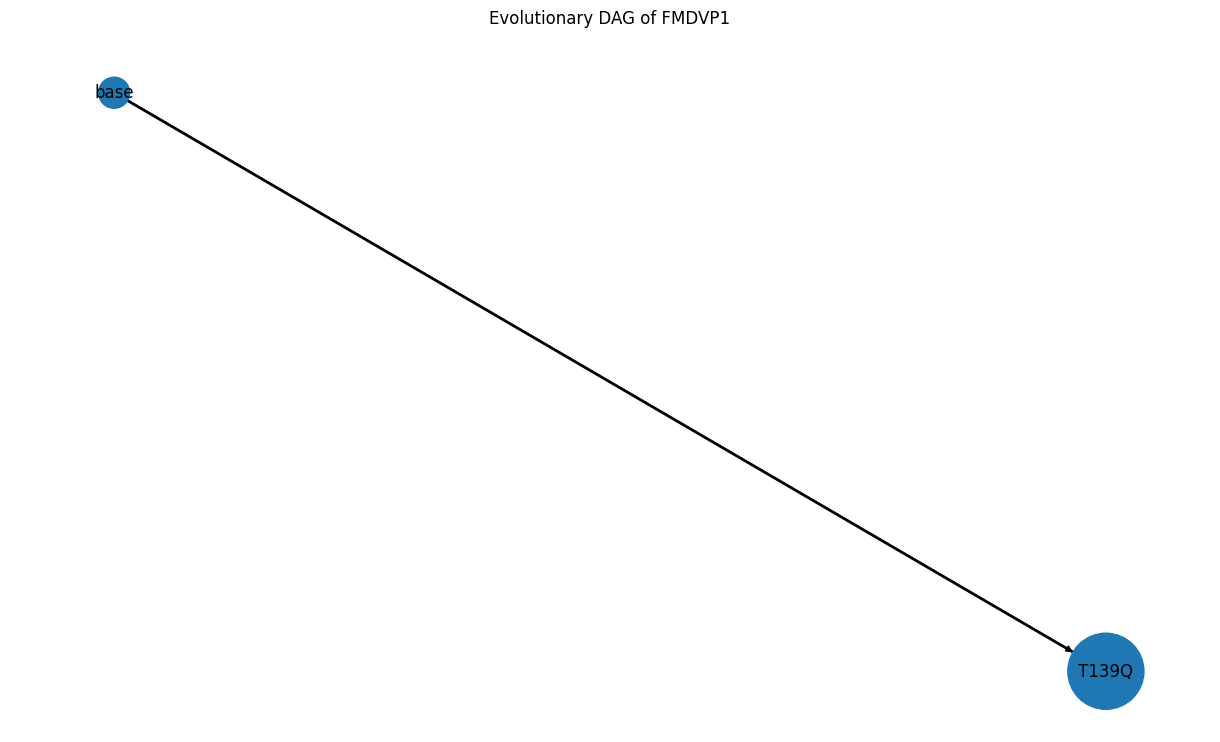

In [21]:
evolution.visualise_graph() 

In [22]:
sorted_best_paths = evolution.get_best_paths_in_order() # paths to leaf nodes only
print(f"Number of paths generated: {len(sorted_best_paths)}") # sorted by mean mutation score for path
# improve evaluation and leave it to filter out potential mutations rather than hardsetting, accept/reject policy, 
# what if i generate 100 different paths, what's the most likely paths that come up? rank these paths, want a population of possible paths  
# use alignments to assess closeness to actual path - ways to evaluate this and quantify the difference 

Number of paths generated: 1


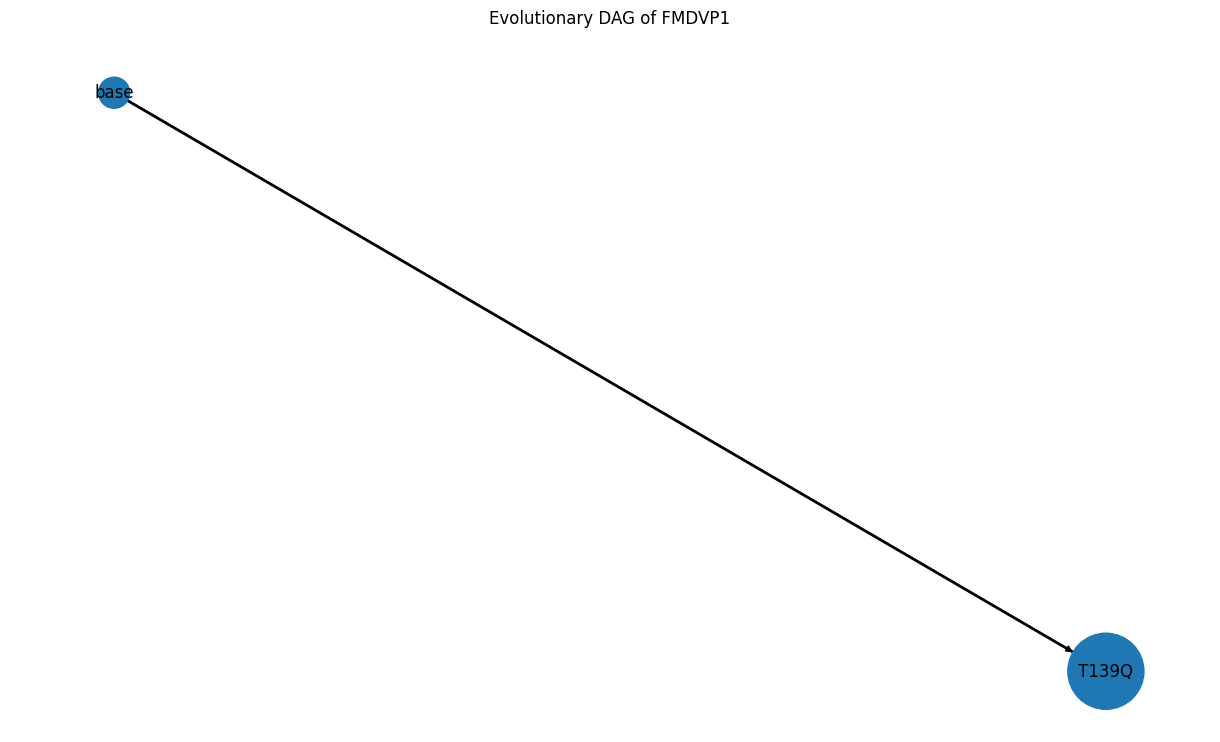

Percentage of mutation matches for base: n/a (root sequence)
% of full segment matches for base: 0.637
% of mutation matches for T139Q: 4.201
% of full segment matches for T139Q: 0.0


In [23]:
best_path = sorted_best_paths[0][1]
evolution.visualise_graph(best_path)
evolution.evaluate_path_using_alignments(evolutionary_path=best_path)

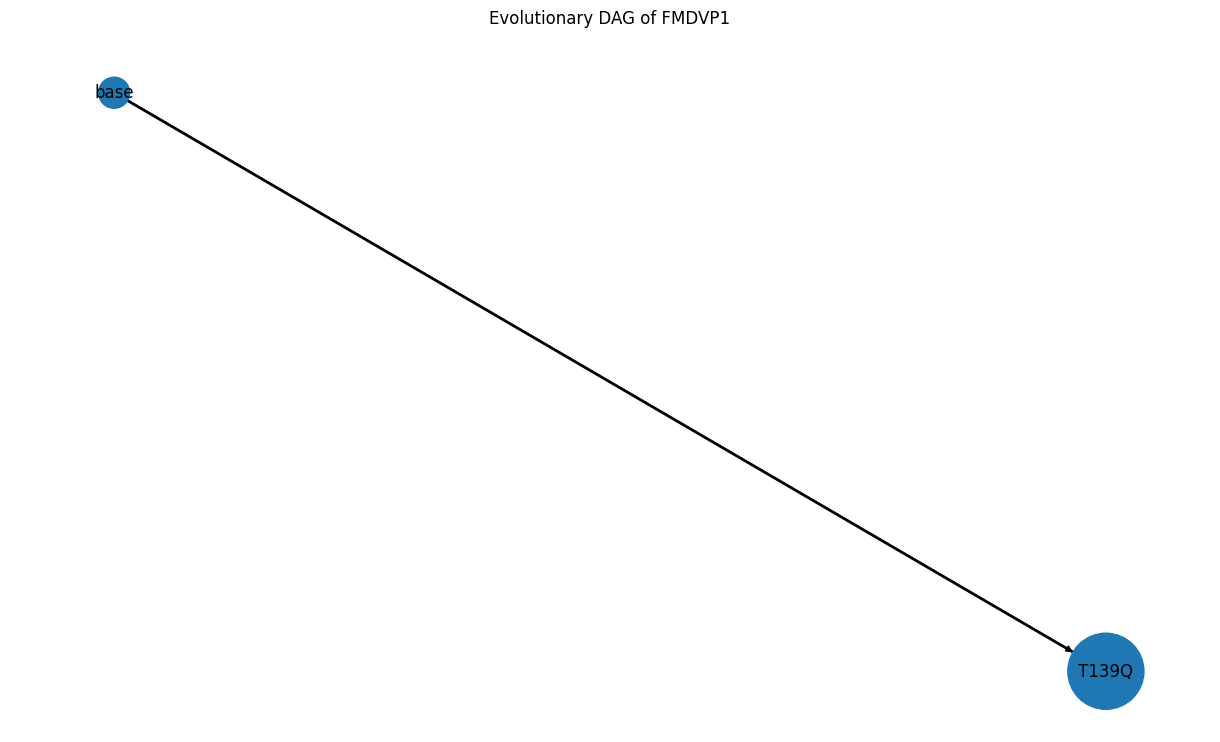

Percentage of mutation matches for base: n/a (root sequence)
% of full segment matches for base: 0.637
% of mutation matches for T139Q: 4.201
% of full segment matches for T139Q: 0.0


In [24]:
worst_path = sorted_best_paths[-1][1]
evolution.visualise_graph(worst_path)
evolution.evaluate_path_using_alignments(evolutionary_path=worst_path)

## Evolution using Mininimum-and Maximum Logits Across All 212 Positions

In [25]:
fmd_sequence = ProteinSequence("base",reference_seq)
eval_strat = EvaluationStrategy(root_sequence = fmd_sequence)
mutation_strat = MinLogitPosSub(mutations_per_seq=mutations_per_seq,start_pos=min_pos,end_pos=max_pos)
evolution = Evolution(
    root_sequence = fmd_sequence,
    mutation_strategy = mutation_strat,
    evaluation_strategy = eval_strat,
    max_generations=max_generations)

In [26]:
evolution.evolve_sequence() 

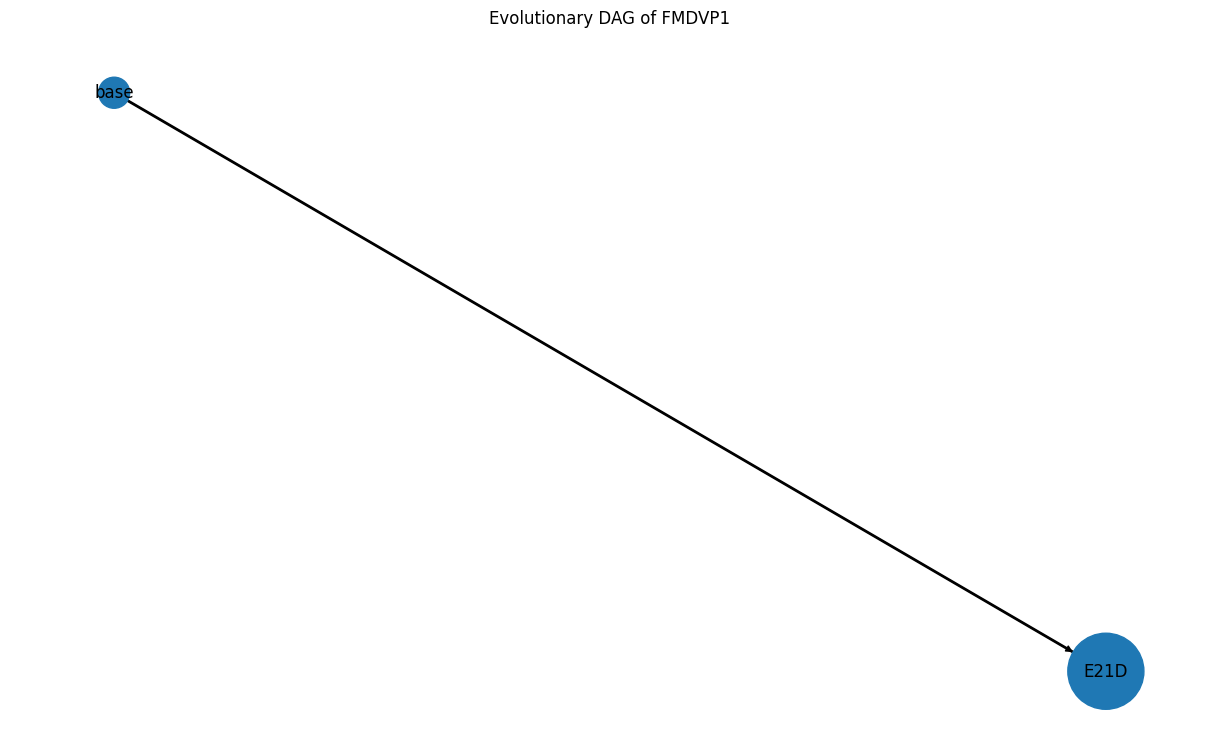

In [27]:
evolution.visualise_graph()

In [28]:
best_path = sorted_best_paths[0][1]
evolution.visualise_graph(best_path)

ValueError: max() arg is an empty sequence

In [ ]:
worst_path = sorted_best_paths[-1][1]
evolution.visualise_graph(worst_path)

## Evolution using Blosum-Weighted Logits Across 6 Highly Mutable Positions

In [ ]:
fmd_sequence = ProteinSequence("base",reference_seq)
eval_strat = EvaluationStrategy(root_sequence=fmd_sequence)
mutation_strat = BlosumWeightedSub(mutations_per_seq=mutations_per_seq,blosum_matrix=blosum_matrix,multiplier=multiplier,start_pos=constrained_start,end_pos=constrained_end)
evolution = Evolution(
    root_sequence = fmd_sequence,
    mutation_strategy = mutation_strat,
    evaluation_strategy = eval_strat,
    max_generations=max_generations)
evolution.process_alignment_data(file_path) # process alignment data

In [ ]:
evolution.evolve_sequence()   

In [ ]:
evolution.visualise_graph()

In [ ]:
sorted_best_paths = evolution.get_best_paths_in_order() # paths to leaf nodes only
print(f"Number of paths generated: {len(sorted_best_paths)}") # sorted by mean mutation score for path

In [ ]:
best_path = sorted_best_paths[0][1]
evolution.visualise_graph(best_path)
evolution.evaluate_path_using_alignments(evolutionary_path=best_path)

In [ ]:
worst_path = sorted_best_paths[-1][1]
evolution.visualise_graph(worst_path)
evolution.evaluate_path_using_alignments(evolutionary_path=worst_path)

## Evolution using Blosum-Weighted Logits Across All 212 Positions

In [ ]:
fmd_sequence = ProteinSequence("base",reference_seq)
eval_strat = EvaluationStrategy(root_sequence = fmd_sequence)
mutation_strat = BlosumWeightedSub(mutations_per_seq=mutations_per_seq,blosum_matrix=blosum_matrix,multiplier=multiplier,start_pos=min_pos,end_pos=max_pos)
evolution = Evolution(
    root_sequence = fmd_sequence,
    mutation_strategy = mutation_strat,
    evaluation_strategy = eval_strat,
    max_generations=max_generations)

In [ ]:
evolution.evolve_sequence()   

In [ ]:
evolution.visualise_graph()

In [ ]:
sorted_best_paths = evolution.get_best_paths_in_order() # paths to leaf nodes only
print(f"Number of paths generated: {len(sorted_best_paths)}") # sorted by mean mutation score for path

In [ ]:
best_path = sorted_best_paths[0][1]
evolution.visualise_graph(best_path)

In [ ]:
worst_path = sorted_best_paths[-1][1]
evolution.visualise_graph(worst_path)

In [ ]:
# prior to changing should_continue_mutating from checking if sequence probability is increasing to checking if overall mutatioon score is increasing and using the minimum average logit score per position rather than the minimum aa logit value
# experiment observation: constraining positions for mutation increases length of evolution path  
# this is not surprising as mutating the position least favoured by the PLM != mutating the position that will yield an increase in sequence probability 
# replacing the current amino acid at the lowest logit position does not automatically increase the sequence probability 
# this is because it may choose a position where mutations are unlikely to happen at to begin  with (ie highly conserved regions) 
# thus leading to an overall decrease on the sequence probability and structure similarity
# When mutations are contrained to positions we know are highly variable from observed data, this aligns with the PLM's knowledge of existing mutations
# such that mutating these highly variable position can lead to higher probability sequences as it expects mutations to occur in these positions